In [1]:
# Install required packages if needed
# !pip install pandas numpy seaborn scikit-learn matplotlib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load Titanic dataset from seaborn
titanic = sns.load_dataset('titanic')

# Display first rows
titanic.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [2]:
# Select a few relevant columns
data = titanic[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]

# Check missing values
data.isnull().sum()


survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
dtype: int64

In [3]:
# Mean Imputation for 'age'
data_mean_imputed = data.copy()
data_mean_imputed['age'] = data_mean_imputed['age'].fillna(data_mean_imputed['age'].mean())


In [5]:
from sklearn.impute import KNNImputer

# Encode categorical variables for imputation
data_knn = data.copy()
data_knn['sex'] = data_knn['sex'].map({'male': 0, 'female': 1})
data_knn['embarked'] = data_knn['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# KNN Imputation
imputer = KNNImputer(n_neighbors=3)
data_knn_imputed_array = imputer.fit_transform(data_knn)
data_knn_imputed = pd.DataFrame(data_knn_imputed_array, columns=data_knn.columns)

# Optional: round categorical features back to integers
data_knn_imputed['sex'] = data_knn_imputed['sex'].round().astype(int)
data_knn_imputed['embarked'] = data_knn_imputed['embarked'].round().astype(int)


In [6]:
data_final = data_mean_imputed.copy()

# One-hot encoding for categorical features
data_final = pd.get_dummies(data_final, columns=['sex', 'embarked'], drop_first=True)
data_final.head()


,survived,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True


In [7]:
X = data_final.drop('survived', axis=1)
y = data_final['survived']


In [8]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import KBinsDiscretizer

# Discretize numerical features
X_binned = X.copy()
binning = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')

for col in ['age', 'fare']:
    X_binned[col] = binning.fit_transform(X_binned[[col]])

# Chi-square test
chi_scores, p_values = chi2(X_binned, y)

chi2_df = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': chi_scores,
    'p-value': p_values
})

chi2_df.sort_values('Chi2 Score', ascending=False)


,Feature,Chi2 Score,p-value
5,sex_male,92.702447,6.077838e-22
0,pclass,30.873699,2.753786e-08
4,fare,29.914098,4.516170e-08
3,parch,10.097499,1.484707e-03
7,embarked_S,5.984840,1.442935e-02
2,sibsp,2.581865,1.080942e-01
1,age,1.784063,1.816513e-01
6,embarked_Q,0.010847,9.170520e-01


In [9]:
from sklearn.feature_selection import f_classif

f_scores, p_values = f_classif(X, y)

anova_df = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_scores,
    'p-value': p_values
})

anova_df.sort_values('F-Score', ascending=False)


,Feature,F-Score,p-value
5,sex_male,372.405724,1.406066e-69
0,pclass,115.031272,2.537047e-25
4,fare,63.030764,6.120189e-15
7,embarked_S,22.075469,3.036111e-06
3,parch,5.963464,1.479925e-02
1,age,4.353516,3.721708e-02
2,sibsp,1.110572,2.922439e-01
6,embarked_Q,0.011846,9.133532e-01


In [10]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)

mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi_scores
})

mi_df.sort_values('Mutual Information', ascending=False)


,Feature,Mutual Information
5,sex_male,0.162344
4,fare,0.143300
0,pclass,0.042846
1,age,0.033065
2,sibsp,0.022404
3,parch,0.018153
6,embarked_Q,0.000000
7,embarked_S,0.000000


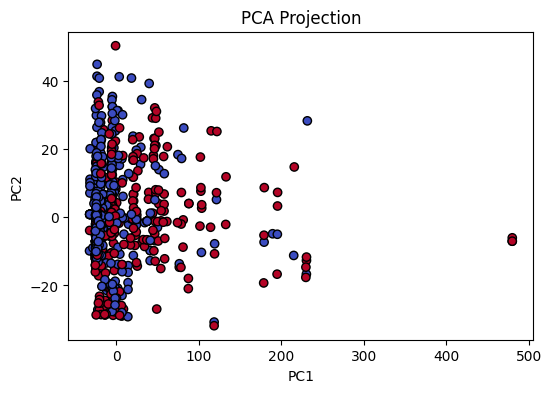

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot
plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', edgecolor='k')
plt.title('PCA Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


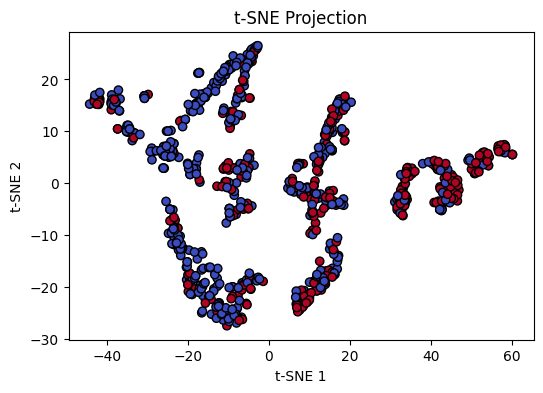

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(6,4))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='coolwarm', edgecolor='k')
plt.title('t-SNE Projection')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()
